In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

DATASET_32M = './ml-32m/'


In [2]:
# Reading CSV files
movies = pd.read_csv(DATASET_32M + 'movies.csv')
ratings = pd.read_csv(DATASET_32M + 'ratings.csv')
tags = pd.read_csv(DATASET_32M + 'tags.csv')

## Movies

In [3]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),Comedy|Drama
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


- using tf-idf for the genres? 

In [4]:
# movies['genres'] = movies['genres'].str.replace('|', ' ')  # Replace '|' with space to treat as text input

# # 2. Apply TF-IDF
# tfidf = TfidfVectorizer()
# tfidf_matrix = tfidf.fit_transform(movies['genres'])  # Generate TF-IDF matrix

#### idea:
- create one-hot encoded features of the movie genres

In [5]:
# Create one-hot encoding for genres
genres = movies['genres'].str.get_dummies()
movies = pd.concat([movies, genres], axis=1)
movies.drop('genres', axis=1, inplace=True)

In [6]:
movies.head(2)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# For each genre column, calculated how many zeros and ones it has
genre_counts = movies.iloc[:, 2:].apply(pd.Series.value_counts)
genre_counts = genre_counts.transpose()
# Choose the column names
genre_counts.columns = ['zeros', 'ones']
# Add total and percentage columns and sort by percentage
genre_counts['total'] = genre_counts['zeros'] + genre_counts['ones']
genre_counts['percentage'] = genre_counts['ones'] / genre_counts['total']
genre_counts.sort_values('percentage', ascending=False, inplace=True)

genre_counts

,zeros,ones,total,percentage
Drama,53410,34175,87585,0.390192
Comedy,64461,23124,87585,0.264018
Thriller,75762,11823,87585,0.134989
Romance,77216,10369,87585,0.118388
Action,77917,9668,87585,0.110384
Documentary,78222,9363,87585,0.106902
Horror,78931,8654,87585,0.098807
(no genres listed),80505,7080,87585,0.080836
Crime,80609,6976,87585,0.079648
Adventure,82183,5402,87585,0.061677


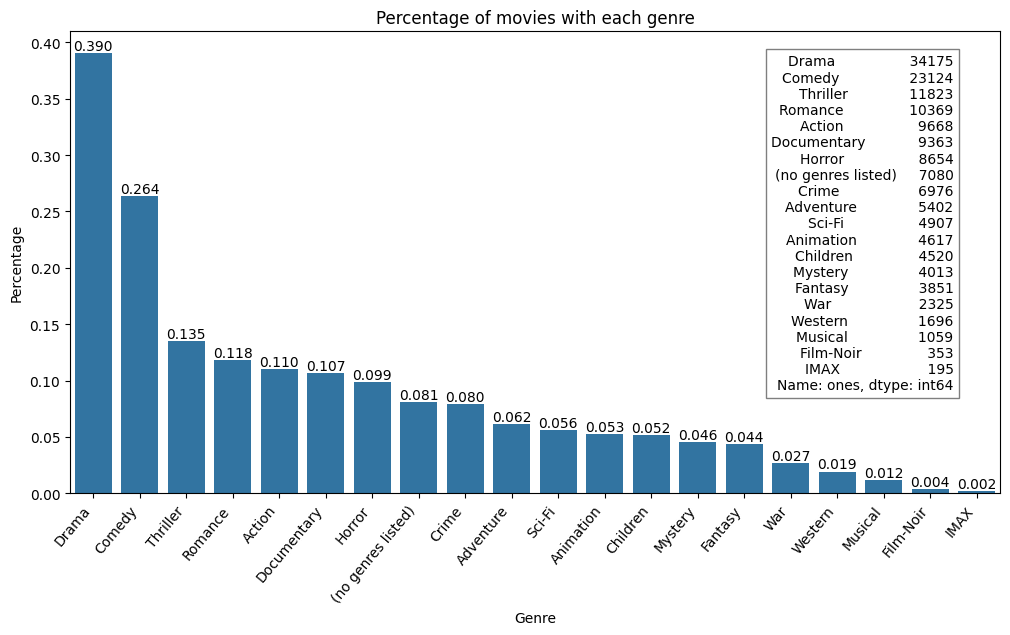

In [8]:
# Visualize the percentage of ones for each genre
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts['percentage'])
plt.xticks(rotation=50, ha='right', va='top')

# Add the percentage values on top of the bars
for i, v in enumerate(genre_counts['percentage']):
    plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')

# Add title and labels
plt.title('Percentage of movies with each genre')
plt.xlabel('Genre')
plt.ylabel('Percentage')

# Add a box in the top right corner with the total number of movies for each genre
plt.text(0.95, 0.95, genre_counts['ones'], transform=plt.gca().transAxes, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

plt.show()


## Tags

In [9]:
tags.head()

,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102


#### idea:
- combine the tags assigned to each movie as a list of tags
- merge it with movies.csv

In [10]:
# Aggreagte the tags for each movie into a list of tags
tags_agg = tags.groupby('movieId')['tag'].agg(list).reset_index()

In [11]:
# Left join the movies with the tags
movies_w_tags = movies.merge(tags_agg, on='movieId', how='left')

In [12]:
movies_w_tags.tag.isna().sum()/len(movies_w_tags)

np.float64(0.41402066563909345)

- it turns out, 41% of the movies don't have any tags, so this idea is a bust

---

## Ratings

In [13]:
ratings

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858
...,...,...,...,...
32000199,200948,79702,4.5,1294412589
32000200,200948,79796,1.0,1287216292
32000201,200948,80350,0.5,1294412671
32000202,200948,80463,3.5,1350423800


In [14]:
ratings.drop('timestamp', axis=1, inplace=True)

#### idea:
- get the average rating for each movie from ratings.csv and add it as a new feature

In [15]:
# Gather the average rating for each movie
avg_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()

In [16]:
avg_ratings

,movieId,rating
0,1,3.897438
1,2,3.275758
2,3,3.139447
3,4,2.845331
4,5,3.059602
...,...,...
84427,292731,4.000000
84428,292737,1.500000
84429,292753,4.000000
84430,292755,1.000000


In [17]:
# Left join the movies with the average ratings
movies = movies.merge(avg_ratings, on='movieId', how='left')

In [18]:
movies.rename(columns={'rating': 'avgRating'}, inplace=True)

In [19]:
movies.avgRating.isna().sum()/len(movies)

np.float64(0.03599931495119027)

- 3.6% of the movies don't have an average rating
- probably due to no one rated them yet

---

#### handling missing values in avgRating
- apply a genre-based averaging
- the filling value will be the average of the genre averages of the movie belongs to

In [20]:
genres = movies.columns[2:-1].values.tolist()
genre_avg_ratings = {}
# Calculate the average rating for each genre
for genre in genres:
    genre_avg_ratings[genre] = movies[movies[genre] == 1]['avgRating'].mean()

In [21]:
def fill_missing_avg_rating(row):
    # If the average rating is missing, calculate it based on the genres
    if np.isnan(row["avgRating"]):
        avg_rating = 0
        count = 0
        # Calculate the average rating based on the genres
        for genre in genres:
            if row[genre] == 1:
                avg_rating += genre_avg_ratings[genre]
                count += 1
        if count > 0:
            avg_rating /= count
        return avg_rating
    
    return row["avgRating"]

movies['avgRating'] = movies.apply(fill_missing_avg_rating, axis=1)

In [22]:
movies["avgRating"].isna().sum()/len(movies)

np.float64(0.0)

---

## Training

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm import tqdm

In [24]:
# Split the data into training and validation sets by creating custom Dataset classes
class RatingDataset(Dataset):
    def __init__(self, movies, ratings):
        self.movies = movies
        self.ratings = ratings
        
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        # Get the features and target for the given index
        features = self.movies.loc[self.ratings.iloc[idx]['movieId']].values
        target = self.ratings.iloc[idx]['rating']
        return features, target

class RatingNN(nn.Module):
    def __init__(self, input_size):
        super(RatingNN, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, 256),  
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        # Three residual blocks with two linear layers each
        self.hidden_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(256, 256), 
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 256),  
                nn.BatchNorm1d(256),
            ) for _ in range(3)  
        ])
        # Transition layer with one linear layer
        self.transition_layer = nn.Sequential(
            nn.Linear(256, 128),  
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        # Final output layer
        self.output_layer = nn.Linear(128, 1)  

    def forward(self, x):
        x = self.input_layer(x)
        for block in self.hidden_layers:
            residual = x
            x = block(x)
            # Residual connection
            x += residual  
            x = F.relu(x)  
        x = self.transition_layer(x)
        return self.output_layer(x)


In [25]:
movies = movies.set_index('movieId').iloc[:, 1:]

In [26]:
# Use all of data
movies_small = movies.sample(frac=1)
# Only keep the ratings for the selected movies
ratings_small = ratings[ratings['movieId'].isin(movies_small.index)]

In [27]:
dataset = RatingDataset(movies_small, ratings_small)

# Train, validation, test split operation
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Random split
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [28]:
# Initialize the model, loss function, and optimizer
input_size = movies.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RatingNN(input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
# Training loop
model.to(device)
n_epochs = 10
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    # Loop over the training data in batches
    for features, target in tqdm(train_loader):
        features = features.float().to(device)
        target = target.float().to(device)
        
        # Zero the gradients and perform the forward pass
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output.squeeze(), target)

        # Perform the backward pass and update the weights
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    # Calculate the average loss over the training data    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Try model on validation data
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for features, target in tqdm(val_loader):
            features = features.float().to(device)
            target = target.float().to(device)

            output = model(features)
            loss = criterion(output.squeeze(), target)

            val_loss += loss.item()
    # Validation Loss  
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

100%|██████████| 100001/100001 [06:37<00:00, 251.27it/s]


Epoch 1/10, Train Loss: 0.9342, Val Loss: 0.9319


100%|██████████| 100001/100001 [06:35<00:00, 252.54it/s]


Epoch 2/10, Train Loss: 0.9290, Val Loss: 0.9333


100%|██████████| 100001/100001 [06:38<00:00, 251.19it/s]


Epoch 3/10, Train Loss: 0.9282, Val Loss: 0.9369


100%|██████████| 100001/100001 [06:42<00:00, 248.66it/s]


Epoch 4/10, Train Loss: 0.9276, Val Loss: 0.9304


100%|██████████| 100001/100001 [06:41<00:00, 249.20it/s]


Epoch 5/10, Train Loss: 0.9273, Val Loss: 0.9408


100%|██████████| 100001/100001 [06:42<00:00, 248.14it/s]


Epoch 6/10, Train Loss: 0.9270, Val Loss: 0.9376


100%|██████████| 100001/100001 [06:41<00:00, 248.98it/s]


Epoch 7/10, Train Loss: 0.9268, Val Loss: 0.9351


100%|██████████| 100001/100001 [06:43<00:00, 247.97it/s]


Epoch 8/10, Train Loss: 0.9266, Val Loss: 0.9322


100%|██████████| 100001/100001 [06:42<00:00, 248.75it/s]


Epoch 9/10, Train Loss: 0.9266, Val Loss: 0.9486


100%|██████████| 100001/100001 [06:37<00:00, 251.77it/s]

Epoch 10/10, Train Loss: 0.9265, Val Loss: 0.9417


In [30]:
# Get the predictions for the test set
model.eval()
test_loss = 0
predictions = []
targets = []
with torch.no_grad():
    # Split into batches
    for features, target in tqdm(test_loader):
        features = features.float().to(device)
        target = target.float().to(device)
        # Get the predictions and calculate the loss
        output = model(features)
        loss = criterion(output.squeeze(), target)

        test_loss += loss.item()
        # Save the predictions and targets
        predictions.extend(output.squeeze().cpu().numpy())
        targets.extend(target.cpu().numpy())

100%|██████████| 50001/50001 [03:21<00:00, 248.31it/s]


In [31]:
# Calculate the MAPE and RMSE
predictions = np.array(predictions)
targets = np.array(targets)
mape = np.mean(np.abs(predictions - targets) / targets) * 100
rmse = np.sqrt(np.mean((predictions - targets) ** 2))

print(f'Test Loss: {test_loss/len(test_loader):.4f}, MAPE: {mape:.2f}%, RMSE: {rmse:.4f}')

Test Loss: 0.9411, MAPE: 35.19%, RMSE: 0.9701
